In [21]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import random
from scipy.interpolate import make_interp_spline


Model constructor functions

In [2]:
def build_MLP(n_nodes=200,activation_func="relu",learning_rate=0.01,input_Shape=[28,28],output_shape=10,use_dropout=False,dropout_rate=0.2,use_l1=False,use_l2=False,l1=0.005,l2=0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_Shape))
    
    if use_l1 and use_l2==False:
        model.add(keras.layers.Dense(n_nodes, activation=activation_func))
    elif use_l1 and use_l2==True:
        model.add(keras.layers.Dense(n_nodes, activation=activation_func,kernel_regularizer=keras.regularizers.L1L2(l1=l1,l2=l2)))
    elif use_l1==True:
        model.add(keras.layers.Dense(n_nodes, activation=activation_func,kernel_regularizer=keras.regularizers.L1(l1=l1)))
    else:
        model.add(keras.layers.Dense(n_nodes, activation=activation_func,kernel_regularizer=keras.regularizers.L2(l2=l2)))

    if use_dropout==True:
        model.add(keras.layers.Dropout(rate=dropout_rate))
        
    model.add(keras.layers.Dense(output_shape, activation="softmax"))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    return model

def build_cnn(n_nodes=128,activation_func="relu",lr=0.01,input_shape=[28,28,1],output_shape=10,use_dropout=True,dropout_rate=0.5,use_l1=False,use_l2=False,l1=0.005,l2=0.005):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64,7,activation=activation_func,padding="same",input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Conv2D(128,3,activation=activation_func,padding="same"))
    model.add(keras.layers.Conv2D(128,3,activation=activation_func,padding="same"))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Flatten())

    if use_l1 and use_l2==False:
        model.add(keras.layers.Dense(n_nodes,activation=activation_func))
    elif use_l1 and use_l2==True:
        model.add(keras.layers.Dense(n_nodes,activation=activation_func,kernel_regularizer=keras.regularizers.L1L2(l1=l1,l2=l2)))
    elif use_l1==True:
        model.add(keras.layers.Dense(n_nodes,activation=activation_func,kernel_regularizer=keras.regularizers.L1(l1=l1)))
    else:
        model.add(keras.layers.Dense(n_nodes,activation=activation_func,kernel_regularizer=keras.regularizers.L2(l2=l2)))

    if use_dropout==True:
        model.add(keras.layers.Dropout(dropout_rate))

    if use_l1 and use_l2==False:
        model.add(keras.layers.Dense(n_nodes/2,activation=activation_func))
    elif use_l1 and use_l2==True:
        model.add(keras.layers.Dense(n_nodes/2,activation=activation_func,kernel_regularizer=keras.regularizers.L1L2(l1=l1,l2=l2)))
    elif use_l1==True:
        model.add(keras.layers.Dense(n_nodes/2,activation=activation_func,kernel_regularizer=keras.regularizers.L1(l1=l1)))
    else:
        model.add(keras.layers.Dense(n_nodes/2,activation=activation_func,kernel_regularizer=keras.regularizers.L2(l2=l2)))

    if use_dropout==True:
        model.add(keras.layers.Dropout(dropout_rate))
        
    model.add(keras.layers.Dense(output_shape,activation="softmax"))

    optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    return model



Data importation and preparation

In [3]:
fashion_mnist=keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_test=X_test/255.0

x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(X_train_full/255.0,y_train_full,test_size=0.1,random_state=42) #random state is used to replicate results

Random search MLP

In [8]:
#hyper parameter tuning through random search
tests=400
n_nodes=np.arange(100)+99
activation_functions=["relu"]
learning_rates=[0.02,0.03]
dropout_changes=[0.1,0.5]
l1_values=[0.01,0.08]
l2_values=[0.1,0.01]
used_parameters=[]
gained_scores=[]
early_stoping=keras.callbacks.EarlyStopping(patience=3,baseline=0.35)
for i in range(tests):
    print("search "+str(i+1))
    nodes=n_nodes[random.randint(0,len(n_nodes)-1)]
    activation=activation_functions[random.randint(0,len(activation_functions)-1)]
    learning_rate=random.uniform(learning_rates[0],learning_rates[1])

    dropout_rate=random.uniform(dropout_changes[0],dropout_changes[1])
    #use_dropout=random.randint(0,1)
    use_dropout=1 #good predictors seem to use dropout
    
    l1_value=random.uniform(l1_values[0],l1_values[1])
    l2_value=random.uniform(l2_values[0],l2_values[1])
    #use_l1=random.randint(0,1)
    use_l1=1 #some of the top predictors usaaly use l1
    use_l2=random.randint(0,1)
    use_l2=0
    

    used_parameters.append([nodes,activation,learning_rate,use_dropout,dropout_rate,use_l1,l1_value,use_l2,l2_value])

    model=build_MLP(n_nodes=nodes,activation_func=activation,learning_rate=learning_rate,use_dropout=use_dropout,dropout_rate=dropout_rate,use_l1=use_l1,use_l2=use_l2,l1=l1_value,l2=l2_value)
    history = model.fit(x_train, y_train, epochs=20,validation_data=(x_val, y_val),callbacks=[early_stoping],verbose=0)
    gained_scores.append(model.evaluate(X_test, y_test,verbose=1)[1])

results=zip(gained_scores,used_parameters)
three_best=sorted(results,reverse=True)[:3]
print(three_best)


search 1
313/313 [==============================] - 0s 821us/step - loss: 0.4452 - accuracy: 0.8403
search 2
313/313 [==============================] - 0s 838us/step - loss: 0.4440 - accuracy: 0.8401
search 3
313/313 [==============================] - 0s 800us/step - loss: 0.4526 - accuracy: 0.8394
search 4
313/313 [==============================] - 0s 841us/step - loss: 0.4383 - accuracy: 0.8420
search 5
313/313 [==============================] - 0s 991us/step - loss: 0.4359 - accuracy: 0.8473
search 6
313/313 [==============================] - 0s 840us/step - loss: 0.4413 - accuracy: 0.8434
search 7
313/313 [==============================] - 0s 884us/step - loss: 0.4345 - accuracy: 0.8452
search 8
313/313 [==============================] - 0s 918us/step - loss: 0.4300 - accuracy: 0.8483
search 9
313/313 [==============================] - 0s 943us/step - loss: 0.4552 - accuracy: 0.8351
search 10
313/313 [==============================] - 0s 895us/step - loss: 0.4481 - accuracy: 0.8394

Random search CNN

In [6]:
tests=80
n_nodes=np.arange(180,step=2)+20
activation_functions=["elu","relu"]
learning_rates=[0.02,0.03]
dropout_changes=[0.05,0.5]
l1_values=[0.01,0.1]
l2_values=[0.01,0.1]
used_cnn_parameters=[]
gained_cnn_scores=[]
early_stoping=keras.callbacks.EarlyStopping(patience=3,baseline=0.35) #voeg baseline=0.35 toe?

for i in range(tests):
    print("search "+str(i+1))
    nodes=n_nodes[random.randint(0,len(n_nodes)-1)]
    activation=activation_functions[random.randint(0,len(activation_functions)-1)]
    learning_rate=random.uniform(learning_rates[0],learning_rates[1])

    dropout_rate=random.uniform(dropout_changes[0],dropout_changes[1])
    use_dropout=random.randint(0,1)
    use_dropout=1 #set in best found parameter
    
    l1_value=random.uniform(l1_values[0],l1_values[1])
    l2_value=random.uniform(l2_values[0],l2_values[1])
    use_l1=random.randint(0,1)
    use_l1=1 #set in best found parameter
    use_l2=random.randint(0,1)
    use_l2=0 #set in best found parameter
    
    used_cnn_parameters.append([nodes,activation,learning_rate,use_dropout,dropout_rate,use_l1,l1_value,use_l2,l2_value])

    model=build_cnn(n_nodes=nodes,activation_func=activation,lr=learning_rate,use_dropout=use_dropout,dropout_rate=dropout_rate,use_l1=use_l1,l1=l1_value,use_l2=use_l2,l2=l2_value)
    history=model.fit(x_train, y_train, epochs=20,validation_data=(x_val, y_val),callbacks=[early_stoping],verbose=0)
    gained_cnn_scores.append(model.evaluate(X_test, y_test,verbose=1)[1])

results_cnn=zip(gained_cnn_scores,used_cnn_parameters)
three_best_cnn=sorted(results_cnn,reverse=True)[:3]
print(three_best_cnn)
    

search 1
313/313 [==============================] - 3s 9ms/step - loss: 0.2584 - accuracy: 0.9138
search 2
313/313 [==============================] - 2s 8ms/step - loss: 0.4546 - accuracy: 0.8407
search 3
313/313 [==============================] - 3s 8ms/step - loss: 0.3892 - accuracy: 0.8582
search 4
313/313 [==============================] - 3s 9ms/step - loss: 0.2641 - accuracy: 0.9115
search 5
313/313 [==============================] - 3s 8ms/step - loss: 0.3835 - accuracy: 0.8583
search 6
313/313 [==============================] - 3s 8ms/step - loss: 0.3671 - accuracy: 0.8641
search 7
313/313 [==============================] - 3s 8ms/step - loss: 0.2633 - accuracy: 0.9073
search 8
313/313 [==============================] - 3s 9ms/step - loss: 0.2694 - accuracy: 0.9083
search 9
313/313 [==============================] - 3s 9ms/step - loss: 0.2802 - accuracy: 0.9056
search 10
313/313 [==============================] - 3s 8ms/step - loss: 0.4025 - accuracy: 0.8510
search 11
313/313 [

CIFAR10 testing MLP

In [25]:
best_found=[(0.8515999913215637, [156, 'relu', 0.02637177668963108, 1, 0.32419478865030876, 1, 0.04976390290213513, 0, 0.03395013831547937]), (0.8510000109672546, [198, 'relu', 0.029520347356332348, 1, 0.23536258496729606, 1, 0.059873948830017364, 0, 0.05713454677342221]), (0.8503000140190125, [189, 'relu', 0.02809111396600398, 1, 0.16248721524821438, 1, 0.05616757386085173, 0, 0.020376609905952928])]

cifar10=keras.datasets.cifar10
(X_train_full_cifar, y_train_full_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
X_test_cifar=X_test_cifar/255.0
x_train_cifar,x_val_cifar,y_train_cifar,y_val_cifar=sklearn.model_selection.train_test_split(X_train_full_cifar/255.0,y_train_full_cifar,test_size=0.1,random_state=40)

mlp_loss_history=[]
mlp_val_loss_history=[]
mlp_accuracy_history=[]
mlp_val_accuracy_history=[]

#voeg dropout en l kansen toe
for i in best_found:
    model=build_MLP(n_nodes=i[1][0],activation_func=i[1][1],learning_rate=i[1][2],input_Shape=[32, 32,3],use_dropout=i[1][3],dropout_rate=i[1][4],use_l1=i[1][5],l1=i[1][6],use_l2=i[1][7],l2=i[1][8])
    mlp_history = model.fit(x_train_cifar, y_train_cifar, epochs=20,validation_data=(x_val_cifar, y_val_cifar),verbose=0)

    mlp_loss_history.append(mlp_history.history['loss'])
    mlp_val_loss_history.append(mlp_history.history['val_loss'])
    mlp_accuracy_history.append(mlp_history.history['accuracy'])
    mlp_val_accuracy_history.append(mlp_history.history['val_accuracy'])

    print(model.evaluate(X_test_cifar, y_test_cifar,verbose=1)[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.5385 - accuracy: 0.4465
0.4465000033378601
313/313 [==============================] - 1s 2ms/step - loss: 1.4573 - accuracy: 0.4826
0.48260000348091125
313/313 [==============================] - 1s 2ms/step - loss: 1.6132 - accuracy: 0.4337
0.43369999527931213


CIFAR10 MLP visualization

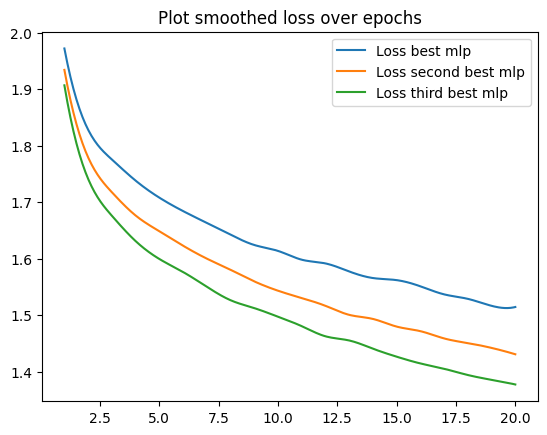

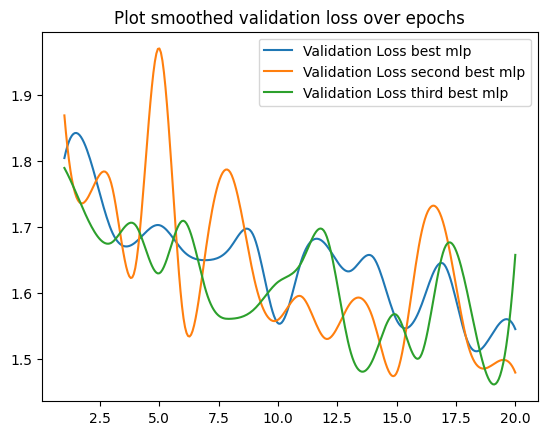

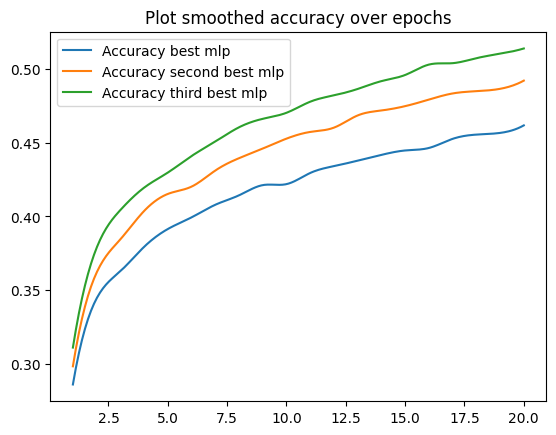

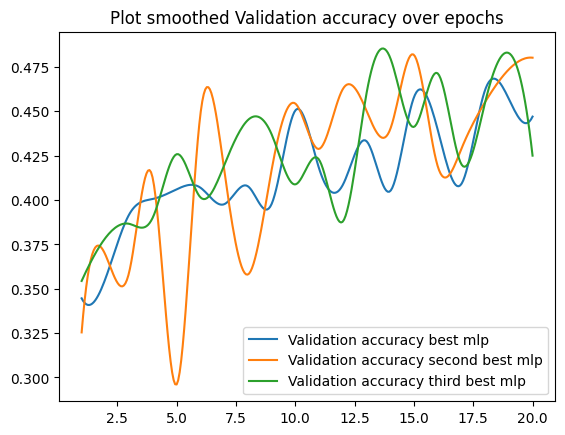

In [49]:

x_values=np.arange(1,21)
new_x=np.linspace(x_values.min(), x_values.max(), 300)

smooth_mlp_accuracy_history=[]
for i in mlp_accuracy_history:
    accuracy_Spline=make_interp_spline(x_values, i)
    new_accuracy=accuracy_Spline(new_x)
    smooth_mlp_accuracy_history.append(new_accuracy)

smooth_mlp_val_accuracy_history=[]
for i in mlp_val_accuracy_history:
    val_accuracy_Spline=make_interp_spline(x_values, i)
    new_accuracy=val_accuracy_Spline(new_x)
    smooth_mlp_val_accuracy_history.append(new_accuracy)

smooth_mlp_loss_history=[]
for i in mlp_loss_history:
    loss_Spline=make_interp_spline(x_values, i)
    new_loss=loss_Spline(new_x)
    smooth_mlp_loss_history.append(new_loss)

smooth_mlp_val_loss_history=[]
for i in mlp_val_loss_history:
    loss_Spline=make_interp_spline(x_values, i)
    new_loss=loss_Spline(new_x)
    smooth_mlp_val_loss_history.append(new_loss)


plt.plot(new_x,smooth_mlp_loss_history[0],label="Loss best mlp")
plt.plot(new_x,smooth_mlp_loss_history[1],label="Loss second best mlp")
plt.plot(new_x,smooth_mlp_loss_history[2],label="Loss third best mlp")
plt.title("Plot smoothed loss over epochs")
plt.legend()
plt.show()


plt.plot(new_x,smooth_mlp_val_loss_history[0],label="Validation Loss best mlp")
plt.plot(new_x,smooth_mlp_val_loss_history[1],label="Validation Loss second best mlp")
plt.plot(new_x,smooth_mlp_val_loss_history[2],label="Validation Loss third best mlp")
plt.title("Plot smoothed validation loss over epochs")
plt.legend()
plt.show()

plt.plot(new_x,smooth_mlp_accuracy_history[0],label="Accuracy best mlp")
plt.plot(new_x,smooth_mlp_accuracy_history[1],label="Accuracy second best mlp")
plt.plot(new_x,smooth_mlp_accuracy_history[2],label="Accuracy third best mlp")
plt.title("Plot smoothed accuracy over epochs")
plt.legend()
plt.show()

plt.plot(new_x,smooth_mlp_val_accuracy_history[0],label="Validation accuracy best mlp")
plt.plot(new_x,smooth_mlp_val_accuracy_history[1],label="Validation accuracy second best mlp")
plt.plot(new_x,smooth_mlp_val_accuracy_history[2],label="Validation accuracy third best mlp")
plt.title("Plot smoothed Validation accuracy over epochs")
plt.legend()
plt.show()








CIFAR10 testing CNN

In [59]:
best_found=[(0.9190000295639038, [148, 'elu', 0.022960289003297125, 1, 0.12428374373913037, 1, 0.0340031076850077, 0, 0.03436777412081317]), (0.9182999730110168, [66, 'elu', 0.02369068191309578, 1, 0.13075060990805798, 1, 0.047228413057575205, 0, 0.07977018993860427]), (0.9162999987602234, [194, 'elu', 0.02272662685938598, 1, 0.2753165399003058, 1, 0.09096976859166983, 0, 0.011635509922194769])]
cifar10=keras.datasets.cifar10
(X_train_full_cifar, y_train_full_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
X_test_cifar=X_test_cifar/255.0
x_train_cifar,x_val_cifar,y_train_cifar,y_val_cifar=sklearn.model_selection.train_test_split(X_train_full_cifar/255.0,y_train_full_cifar,test_size=0.1,random_state=40)

cnn_loss_history=[]
cnn_val_loss_history=[]
cnn_accuracy_history=[]
cnn_val_accuracy_history=[]

for i in best_found:
    model=build_cnn(n_nodes=i[1][0],activation_func=i[1][1],input_shape=[32,32,3],lr=i[1][2],use_dropout=i[1][3],dropout_rate=i[1][4],use_l1=i[1][5],l1=i[1][6],use_l2=i[1][7],l2=i[1][8])
    cnn_history = model.fit(x_train_cifar, y_train_cifar, epochs=20,validation_data=(x_val_cifar, y_val_cifar),verbose=0)

    cnn_loss_history.append(cnn_history.history['loss'])
    cnn_val_loss_history.append(cnn_history.history['val_loss'])
    cnn_accuracy_history.append(cnn_history.history['accuracy'])
    cnn_val_accuracy_history.append(cnn_history.history['val_accuracy'])

    print(model.evaluate(X_test_cifar, y_test_cifar,verbose=1)[1])

313/313 [==============================] - 8s 26ms/step - loss: 1.6205 - accuracy: 0.6865
0.6865000128746033
313/313 [==============================] - 8s 26ms/step - loss: 1.5125 - accuracy: 0.6556
0.6556000113487244
313/313 [==============================] - 9s 30ms/step - loss: 1.3349 - accuracy: 0.6719
0.6718999743461609


CIFAR10 CNN visualization

[0.41288888454437256, 0.5477111339569092, 0.6012222170829773, 0.6438444256782532, 0.6755111217498779, 0.7025333046913147, 0.7322221994400024, 0.7565777897834778, 0.7816222310066223, 0.8053777813911438, 0.8289555311203003, 0.8495110869407654, 0.8698222041130066, 0.8843333125114441, 0.9000666737556458, 0.9132221937179565, 0.9235110878944397, 0.9346666932106018, 0.9400666952133179, 0.9484221935272217]
[0.3980666697025299, 0.5322666764259338, 0.5851555466651917, 0.6211555600166321, 0.652044415473938, 0.6747111082077026, 0.6950444579124451, 0.7146000266075134, 0.7331333160400391, 0.7537111043930054, 0.7733111381530762, 0.7931333184242249, 0.8101111054420471, 0.8240666389465332, 0.83724445104599, 0.8545555472373962, 0.8685333132743835, 0.877644419670105, 0.8917555809020996, 0.90102219581604]
[0.41288888 0.49437582 0.54565273 0.57708536 0.59903948 0.62028863
 0.64085474 0.65821131 0.67269121 0.68576416 0.69888879 0.71327302
 0.72790323 0.74079622 0.75231786 0.7641688  0.77650811 0.78844114
 0

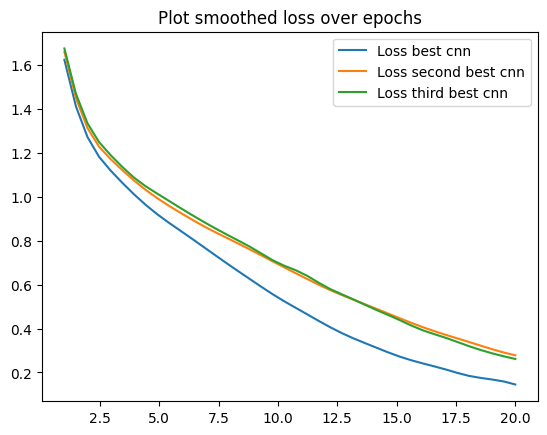

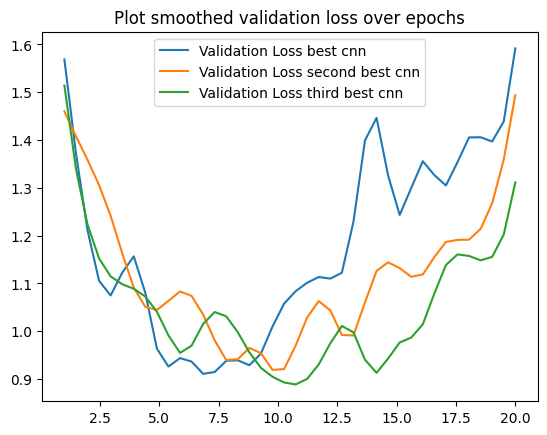

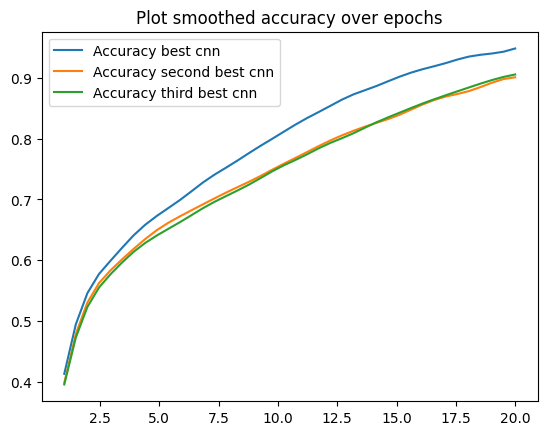

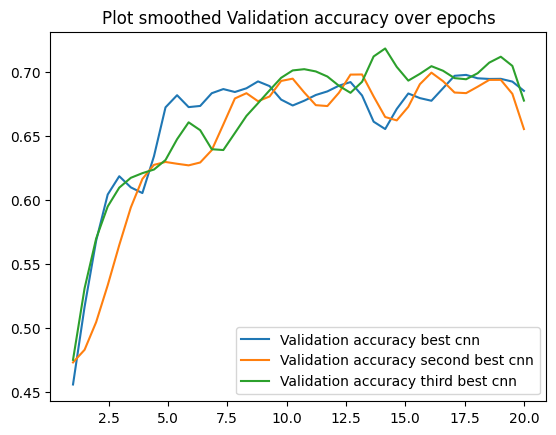

In [62]:
x_values=np.arange(1,21)
new_x=np.linspace(x_values.min(), x_values.max(), 40)

smooth_cnn_accuracy_history=[]
for i in cnn_accuracy_history:
    accuracy_Spline=make_interp_spline(x_values, i)
    new_accuracy=accuracy_Spline(new_x)
    smooth_cnn_accuracy_history.append(new_accuracy)

smooth_cnn_val_accuracy_history=[]
for i in cnn_val_accuracy_history:
    val_accuracy_Spline=make_interp_spline(x_values, i)
    new_accuracy=val_accuracy_Spline(new_x)
    smooth_cnn_val_accuracy_history.append(new_accuracy)

smooth_cnn_loss_history=[]
for i in cnn_loss_history:
    loss_Spline=make_interp_spline(x_values, i)
    new_loss=loss_Spline(new_x)
    smooth_cnn_loss_history.append(new_loss)

smooth_cnn_val_loss_history=[]
for i in cnn_val_loss_history:
    loss_Spline=make_interp_spline(x_values, i)
    new_loss=loss_Spline(new_x)
    smooth_cnn_val_loss_history.append(new_loss)

plt.plot(new_x,smooth_cnn_loss_history[0],label="Loss best cnn")
plt.plot(new_x,smooth_cnn_loss_history[1],label="Loss second best cnn")
plt.plot(new_x,smooth_cnn_loss_history[2],label="Loss third best cnn")
plt.title("Plot smoothed loss over epochs")
plt.legend()
plt.show()

plt.plot(new_x,smooth_cnn_val_loss_history[0],label="Validation Loss best cnn")
plt.plot(new_x,smooth_cnn_val_loss_history[1],label="Validation Loss second best cnn")
plt.plot(new_x,smooth_cnn_val_loss_history[2],label="Validation Loss third best cnn")
plt.title("Plot smoothed validation loss over epochs")
plt.legend()
plt.show()

plt.plot(new_x,smooth_cnn_accuracy_history[0],label="Accuracy best cnn")
plt.plot(new_x,smooth_cnn_accuracy_history[1],label="Accuracy second best cnn")
plt.plot(new_x,smooth_cnn_accuracy_history[2],label="Accuracy third best cnn")
plt.title("Plot smoothed accuracy over epochs")
plt.legend()
plt.show()

plt.plot(new_x,smooth_cnn_val_accuracy_history[0],label="Validation accuracy best cnn")
plt.plot(new_x,smooth_cnn_val_accuracy_history[1],label="Validation accuracy second best cnn")
plt.plot(new_x,smooth_cnn_val_accuracy_history[2],label="Validation accuracy third best cnn")
plt.title("Plot smoothed Validation accuracy over epochs")
plt.legend()
plt.show()
